In [316]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [317]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/dati_trattati.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])

# Replace inf and -inf with NaN
#df.replace(['inf', '-inf', np.inf, -np.inf], np.nan, inplace=True)

df = df.dropna(subset=['relative_quarterly_return'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14322 entries, 1 to 15338
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gvkey                      14322 non-null  int64         
 1   datadate                   14322 non-null  datetime64[ns]
 2   tic                        14322 non-null  object        
 3   actq                       14322 non-null  float64       
 4   ancq                       14322 non-null  float64       
 5   epsfxq                     14302 non-null  float64       
 6   lctq                       14322 non-null  float64       
 7   ltq                        14322 non-null  float64       
 8   revtq                      14322 non-null  float64       
 9   capxy                      13783 non-null  float64       
 10  roa                        14289 non-null  float64       
 11  roe                        14097 non-null  float64       
 12  pe_i

In [318]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

#df.to_csv('check_data.csv', index=False)  # Set index=False to exclude the index column

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6953 entries, 2164 to 3737
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gvkey                      6953 non-null   int64         
 1   datadate                   6953 non-null   datetime64[ns]
 2   tic                        6953 non-null   object        
 3   actq                       6953 non-null   float64       
 4   ancq                       6953 non-null   float64       
 5   epsfxq                     6953 non-null   float64       
 6   lctq                       6953 non-null   float64       
 7   ltq                        6953 non-null   float64       
 8   revtq                      6953 non-null   float64       
 9   capxy                      6953 non-null   float64       
 10  roa                        6953 non-null   float64       
 11  roe                        6953 non-null   float64       
 12  pe_

In [319]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2012-03-31'

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)].sort_values(by=['tic', 'datadate'])
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)].sort_values(by=['tic', 'datadate'])
test_df = df[(df['datadate'] >= test_start_date)].sort_values(by=['tic', 'datadate'])

train_df.head()

,gvkey,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,...,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,target,spindx,spindx_change,prccq,prccq_change
32,1690,1988-12-31,AAPL,0.079635,0.174100,0.309524,0.036776,0.050238,0.202288,-0.486344,...,0.007246,-0.129302,0.109926,-0.144798,-0.090732,-0.176660,277.72,0.021367,40.250,-0.069364
33,1690,1989-03-31,AAPL,-0.002265,0.140199,-0.600000,-0.069827,-0.015156,-0.112601,0.678100,...,0.741007,0.028846,-0.025073,0.236976,-0.176660,0.079521,294.87,0.061753,35.625,-0.114907
34,1690,1989-06-30,AAPL,0.021059,0.097413,0.681818,-0.063730,-0.031102,0.001039,0.444418,...,0.293388,-0.019730,0.007287,-0.132255,0.079521,-0.019237,317.98,0.078374,41.250,0.157895
35,1690,1989-09-30,AAPL,0.169988,0.022918,0.675676,0.198772,0.163898,0.108583,0.333019,...,-0.137380,-0.102754,0.090638,-0.105653,-0.019237,-0.220038,349.15,0.098025,44.500,0.078788
36,1690,1989-12-31,AAPL,0.013564,0.085242,-0.225806,-0.002874,0.024924,0.079231,-0.736946,...,-0.162963,0.011806,-0.004682,-0.266711,-0.220038,0.179931,353.40,0.012172,35.250,-0.207865


In [320]:
results = test_df[['datadate', 'tic', 'spindx', 'spindx_change', 'prccq', 'prccq_change', 'target']].copy()

drop_cols = ['gvkey', 'datadate', 'tic', 'spindx', 'spindx_change', 'prccq', 'prccq_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,pe_inc,...,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,target
32,0.079635,0.174100,0.309524,0.036776,0.050238,0.202288,-0.486344,0.422,0.366,11.120,...,-0.016981,-0.084596,-0.025641,-0.030612,0.007246,-0.129302,0.109926,-0.144798,-0.090732,-0.176660
33,-0.002265,0.140199,-0.600000,-0.069827,-0.015156,-0.112601,0.678100,0.373,0.320,15.453,...,-0.024952,0.017669,-0.114035,-0.136842,0.741007,0.028846,-0.025073,0.236976,-0.176660,0.079521
34,0.021059,0.097413,0.681818,-0.063730,-0.031102,0.001039,0.444418,0.355,0.300,14.263,...,-0.003937,-0.057186,-0.009901,-0.036585,0.293388,-0.019730,0.007287,-0.132255,0.079521,-0.019237
35,0.169988,0.022918,0.675676,0.198772,0.163898,0.108583,0.333019,0.315,0.293,12.535,...,0.015810,0.092809,0.100000,0.088608,-0.137380,-0.102754,0.090638,-0.105653,-0.019237,-0.220038
36,0.013564,0.085242,-0.225806,-0.002874,0.024924,0.079231,-0.736946,0.319,0.272,10.059,...,0.023346,-0.140966,-0.009091,-0.046512,-0.162963,0.011806,-0.004682,-0.266711,-0.220038,0.179931


In [321]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target',], 1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target',], 1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target',], 1)

X_train.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,pe_inc,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
32,0.079635,0.174100,0.309524,0.036776,0.050238,0.202288,-0.486344,0.422,0.366,11.120,...,-0.491803,-0.016981,-0.084596,-0.025641,-0.030612,0.007246,-0.129302,0.109926,-0.144798,-0.090732
33,-0.002265,0.140199,-0.600000,-0.069827,-0.015156,-0.112601,0.678100,0.373,0.320,15.453,...,0.591398,-0.024952,0.017669,-0.114035,-0.136842,0.741007,0.028846,-0.025073,0.236976,-0.176660
34,0.021059,0.097413,0.681818,-0.063730,-0.031102,0.001039,0.444418,0.355,0.300,14.263,...,0.108108,-0.003937,-0.057186,-0.009901,-0.036585,0.293388,-0.019730,0.007287,-0.132255,0.079521
35,0.169988,0.022918,0.675676,0.198772,0.163898,0.108583,0.333019,0.315,0.293,12.535,...,-0.542683,0.015810,0.092809,0.100000,0.088608,-0.137380,-0.102754,0.090638,-0.105653,-0.019237
36,0.013564,0.085242,-0.225806,-0.002874,0.024924,0.079231,-0.736946,0.319,0.272,10.059,...,0.440000,0.023346,-0.140966,-0.009091,-0.046512,-0.162963,0.011806,-0.004682,-0.266711,-0.220038


In [322]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,capxy,roa,roe,pe_inc,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
0,0.171786,0.247196,0.431440,0.082550,0.221317,0.147503,0.105831,0.877358,0.390921,0.493672,...,0.077187,0.812562,0.782552,0.361872,0.587785,0.463137,0.105279,0.334475,0.083846,0.342361
1,0.158729,0.240047,0.420482,0.074058,0.207519,0.105719,0.345746,0.862447,0.371585,0.500146,...,0.087725,0.812506,0.787567,0.355791,0.586223,0.464949,0.137938,0.284476,0.125708,0.292342
2,0.162448,0.231025,0.435926,0.074544,0.204154,0.120798,0.297599,0.856969,0.363178,0.498368,...,0.083023,0.812655,0.783896,0.362955,0.587697,0.463844,0.127907,0.296461,0.085221,0.441466
3,0.186190,0.215316,0.435852,0.095455,0.245298,0.135069,0.274647,0.844796,0.360235,0.495787,...,0.076692,0.812795,0.791252,0.370516,0.589538,0.462780,0.110762,0.327331,0.088138,0.383978
4,0.161253,0.228458,0.424990,0.079392,0.215975,0.131174,0.054198,0.846013,0.351408,0.492087,...,0.086252,0.812849,0.779787,0.363011,0.587551,0.462716,0.134419,0.292028,0.070478,0.267092


In [323]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.1],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:29:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:29:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:29:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:29:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[12:29:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.24293263081544056
CPU times: user 21.2 s, sys: 916 ms, total: 22.1 s
Wall time: 3.54 s


In [324]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

CPU times: user 5.83 s, sys: 256 ms, total: 6.09 s
Wall time: 918 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

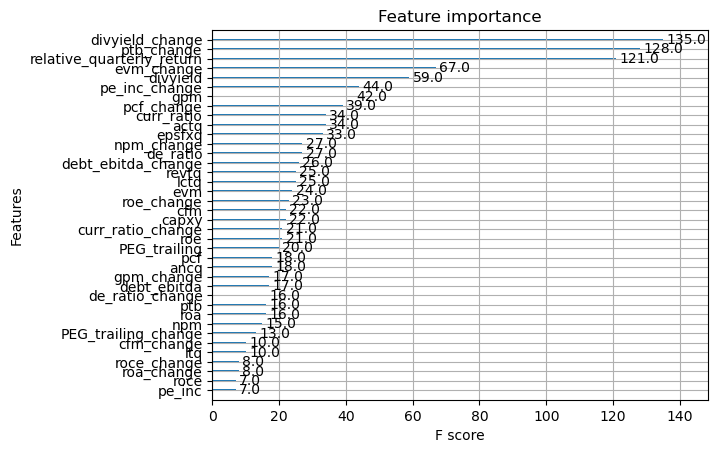

In [325]:
plot_importance(model);

In [326]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(classification_report(y_test_binary, y_test_pred_binary))



              precision    recall  f1-score   support

           0       0.74      0.61      0.67       992
           1       0.66      0.77      0.71       956

    accuracy                           0.69      1948
   macro avg       0.70      0.69      0.69      1948
weighted avg       0.70      0.69      0.69      1948



In [327]:
results['y_pred'] = y_test_pred

results.head()

,datadate,tic,spindx,spindx_change,prccq,prccq_change,target,y_pred
131,2013-09-30,AAPL,1681.55,0.041233,476.75,0.202305,0.077559,0.046483
132,2013-12-31,AAPL,1848.36,0.099200,561.02,0.176759,-0.056252,-0.020105
135,2014-09-30,AAPL,1972.29,0.006152,100.75,0.084149,0.051670,0.062161
139,2015-09-30,AAPL,1920.03,-0.069352,110.30,-0.120590,-0.110229,0.028828
143,2016-09-30,AAPL,2168.27,0.033070,113.05,0.182531,-0.008040,-0.004443
